In [1]:
pip install matplotlib pandas

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 kB 1.9 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 41.3 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 64.3 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 305.2/305.2 kB 31.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.6/4.6 MB 82.1 MB/s eta 0:00:00ta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 112.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.2/103.2 kB 14.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 345.4/345.4 kB 53.9 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


# สุ่มพื้นที่ขนาด 7x7 เพื่อลบข้อมูลในภาพออก

In [2]:
# prompt: create a function to randomly put a black box size 7*7 inside the given gray scale image then return the processed image and the mask.

import numpy as np
def create_masked_image(image):
  """
  Randomly puts a black box of size 7x7 inside the given grayscale image.

  Args:
    image: A NumPy array representing a grayscale image.

  Returns:
    A tuple containing:
      - The processed image with the black box.
      - The corresponding mask with 1s where the box is and 0s elsewhere.
  """

  # Create a copy of the image to avoid modifying the original.
  processed_image = image.copy()

  # Generate random coordinates for the top-left corner of the box.
  x = np.random.randint(0, image.shape[0] - 7)
  y = np.random.randint(0, image.shape[1] - 7)

  # Create the black box on the processed image.
  processed_image[x:x+7, y:y+7] = 0

  # Create the mask.
  mask = np.zeros_like(image)
  mask[x:x+7, y:y+7] = 1

  return processed_image, mask


# สร้าง Dataset เพื่อเตรียมใช้กับการฝึก

In [3]:
# prompt: create Dataset to load image from a given folder preprocess with function create_masked_image() and a given transformation then return image, processed image and mask

import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import os

class ImageInpaintingDataset(Dataset):
  def __init__(self, image_dir, transform=None):
    self.image_dir = image_dir
    self.image_files = [f for f in os.listdir(image_dir) if f.endswith('.jpg') or f.endswith('.png')]
    self.transform = transform

  def __len__(self):
    return len(self.image_files)

  def __getitem__(self, idx):
    img_path = os.path.join(self.image_dir, self.image_files[idx])
    image = Image.open(img_path).convert('L')  # Convert to grayscale

    if self.transform:
      image = self.transform(image)

    processed_image, mask = create_masked_image(np.array(image))

    # Convert to PyTorch tensors
    image = transforms.ToTensor()(image)
    processed_image = transforms.ToTensor()(processed_image)
    mask = transforms.ToTensor()(mask)

    return image, processed_image, mask

# Example usage:
transform = transforms.Compose([
    # transforms.Resize((256, 256))
    # Add other transformations as needed
])


# สร้าง dataloader แบบประมวลผลภาพเบื้องต้นโดยใช้หลายซีพียูคอร์

In [8]:
# prompt: create data loader from /content/train, and /content/val in parallel by automatically get appropriate number of cpu core

import multiprocessing

# Get the number of CPU cores
num_workers = multiprocessing.cpu_count()

# Create datasets
train_dataset = ImageInpaintingDataset('/workspace/train', transform=transform)
val_dataset = ImageInpaintingDataset('/workspace/test', transform=transform)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=200, shuffle=True, num_workers=num_workers)
val_loader = DataLoader(val_dataset, batch_size=200, shuffle=False, num_workers=num_workers)


# สร้าง GAN โมเดล

In [6]:
import torch

# Create a tensor with shape [5, 1, 64, 64]
train_images = torch.randn(5, 1, 64, 64)

# Normalize the values to be between -1 and 1
train_images = torch.clamp(train_images, -1, 1)

In [4]:
# prompt: create Generative Adversarial Networks (GANs) model to fill in the black box to complete the image. the input image is gray scale 64*64 image with the black box and output is the complete image in the same size

import torch.nn as nn

# Generator
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Tanh()  # Output pixel values in range [-1, 1]
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

# Discriminator
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(64, 1, kernel_size=3, padding=1),
            nn.Sigmoid()  # Output probability of real image
        )

    def forward(self, x):
        return self.model(x)


In [6]:
import torch
import torch.nn as nn

class MappingNetwork(nn.Module):
    def __init__(self, input_dim, w_dim, num_layers):
        super().__init__()
        self.layers = nn.ModuleList([
            nn.Linear(input_dim if i == 0 else w_dim, w_dim)
            for i in range(num_layers)
        ])
    
    def forward(self, x):
        w = x
        for layer in self.layers:
            w = layer(w)
            w = torch.nn.functional.leaky_relu(w, 0.2)
        return w

class AdaptiveInstanceNorm(nn.Module):
    def __init__(self, num_features, w_dim):
        super().__init__()
        self.instance_norm = nn.InstanceNorm2d(num_features)
        self.style_scale = nn.Linear(w_dim, num_features)
        self.style_bias = nn.Linear(w_dim, num_features)
    
    def forward(self, x, w):
        normalized = self.instance_norm(x)
        scale = self.style_scale(w).unsqueeze(2).unsqueeze(3)
        bias = self.style_bias(w).unsqueeze(2).unsqueeze(3)
        return normalized * scale + bias

class ResBlock(nn.Module):
    def __init__(self, in_channels, out_channels, w_dim):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.adain1 = AdaptiveInstanceNorm(out_channels, w_dim)
        self.adain2 = AdaptiveInstanceNorm(out_channels, w_dim)
        self.skip = nn.Conv2d(in_channels, out_channels, kernel_size=1) if in_channels != out_channels else nn.Identity()
    
    def forward(self, x, w):
        residual = self.skip(x)
        x = self.conv1(x)
        x = self.adain1(x, w)
        x = torch.nn.functional.leaky_relu(x, 0.2)
        x = self.conv2(x)
        x = self.adain2(x, w)
        x = torch.nn.functional.leaky_relu(x, 0.2)
        return x + residual

class Generator(nn.Module):
    def __init__(self, input_channels=1, output_channels=1, w_dim=512, num_layers=8):
        super().__init__()
        self.input_conv = nn.Conv2d(input_channels, 64, kernel_size=3, padding=1)
        self.mapping = MappingNetwork(64*64*64, w_dim, num_layers)
        
        self.down_blocks = nn.ModuleList([
            ResBlock(64, 128, w_dim),
            ResBlock(128, 256, w_dim),
            ResBlock(256, 512, w_dim),
        ])
        
        self.up_blocks = nn.ModuleList([
            ResBlock(512, 256, w_dim),
            ResBlock(256, 128, w_dim),
            ResBlock(128, 64, w_dim),
        ])
        
        self.output_conv = nn.Conv2d(64, output_channels, kernel_size=3, padding=1)
    
    def forward(self, x):
        x = self.input_conv(x)
        
        # Generate w from the input image
        w = self.mapping(x.view(x.size(0), -1))
        
        # Downsampling
        skip_connections = []
        for block in self.down_blocks:
            x = block(x, w)
            skip_connections.append(x)
            x = nn.functional.avg_pool2d(x, 2)
        
        # Upsampling
        for block, skip in zip(self.up_blocks, reversed(skip_connections)):
            x = nn.functional.interpolate(x, scale_factor=2, mode='nearest')
            x = x + skip
            x = block(x, w)
        
        x = self.output_conv(x)
        return torch.tanh(x)  # Ensure output is in range [-1, 1]

class Discriminator(nn.Module):
    def __init__(self, input_channels=1):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Conv2d(input_channels, 64, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),
            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2),
            nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        return self.layers(x).view(-1, 1)



In [7]:
# Example usage
generator = Generator(input_channels=1, output_channels=1)
discriminator = Discriminator(input_channels=1)

# Generate a fake image
input_image = torch.randn(5, 1, 64, 64)
fake_image = generator(input_image)

# Discriminate the fake image
disc_output = discriminator(fake_image)
print(fake_image.shape)
disc_output.shape


torch.Size([5, 1, 64, 64])


torch.Size([5, 1])

# สร้างฟังก์ชัน train ที่มีการตรวจสอบ overfitting ด้วยแนวคิด early stopping

In [9]:
# prompt: create the train function with early stopping to monitor validation loss

def train(generator, discriminator, train_loader, val_loader, num_epochs, criterion_gan, criterion_pixelwise, optimizer_g, optimizer_d, device):
    """
    Trains the generator and discriminator models.

    Args:
        generator: The generator model.
        discriminator: The discriminator model.
        train_loader: DataLoader for the training dataset.
        val_loader: DataLoader for the validation dataset.
        num_epochs: Number of epochs to train for.
        criterion_gan: Loss function for the GAN (e.g., Binary Cross Entropy).
        criterion_pixelwise: Loss function for pixel-wise reconstruction (e.g., L1 loss).
        optimizer_g: Optimizer for the generator.
        optimizer_d: Optimizer for the discriminator.
        device: Device to run the training on (e.g., 'cuda' or 'cpu').
    """

    best_val_loss = float('inf')
    patience = 100  # Number of epochs to wait for improvement
    epochs_without_improvement = 0

    for epoch in range(num_epochs):
        generator.train()
        discriminator.train()
        train_loss_g = 0
        train_loss_d = 0

        for batch_idx, (original_images, masked_images, masks) in enumerate(train_loader):
            original_images = original_images.to(device)
            masked_images = masked_images.to(device)
            masks = masks.to(device)

            # Train Discriminator
            optimizer_d.zero_grad()
            # Real images
            real_outputs = discriminator(original_images)
            real_loss = criterion_gan(real_outputs, torch.ones_like(real_outputs))
            # Generated images
            generated_images = generator(masked_images)
            fake_outputs = discriminator(generated_images.detach())  # Detach to avoid training generator here
            fake_loss = criterion_gan(fake_outputs, torch.zeros_like(fake_outputs))
            # Total discriminator loss
            loss_d = real_loss + fake_loss
            loss_d.backward()
            optimizer_d.step()
            train_loss_d += loss_d.item()

            # Train Generator
            optimizer_g.zero_grad()
            # Adversarial loss
            fake_outputs = discriminator(generated_images)
            loss_gan = criterion_gan(fake_outputs, torch.ones_like(fake_outputs))
            # Pixel-wise reconstruction loss
            loss_pixelwise = criterion_pixelwise(generated_images, original_images)
            # Total generator loss
            loss_g = loss_gan + loss_pixelwise
            loss_g.backward()
            optimizer_g.step()
            train_loss_g += loss_g.item()

        # Calculate average training losses
        train_loss_g /= len(train_loader)
        train_loss_d /= len(train_loader)

        # Validation
        generator.eval()
        discriminator.eval()
        val_loss = 0
        with torch.no_grad():
            for original_images, masked_images, masks in val_loader:
                original_images = original_images.to(device)
                masked_images = masked_images.to(device)
                masks = masks.to(device)

                generated_images = generator(masked_images)
                loss_pixelwise = criterion_pixelwise(generated_images, original_images)
                val_loss += loss_pixelwise.item()

        val_loss /= len(val_loader)

        print(f"Epoch [{epoch+1}/{num_epochs}] Train Loss G: {train_loss_g:.4f}, Train Loss D: {train_loss_d:.4f}, Val Loss: {val_loss:.4f}")

        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            epochs_without_improvement = 0
            # Save the best model (optional)
            # torch.save(generator.state_dict(), 'best_generator.pth')
        else:
            epochs_without_improvement += 1
            if epochs_without_improvement >= patience:
                print("Early stopping triggered.")
                break


#Train Model

In [22]:
# prompt: create the loss functions, optimizer and then train the model

# Initialize models and move to device

# Initialize models and move to device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
generator = Generator().to(device)
discriminator = Discriminator().to(device)



# Loss functions
criterion_gan = nn.BCELoss()
criterion_pixelwise = nn.L1Loss()

# Optimizers
optimizer_g = torch.optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_d = torch.optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

# Train the model
train(generator, discriminator, train_loader, val_loader, num_epochs=1000,
      criterion_gan=criterion_gan, criterion_pixelwise=criterion_pixelwise,
      optimizer_g=optimizer_g, optimizer_d=optimizer_d, device=device)


Epoch [1/1000] Train Loss G: 0.9446, Train Loss D: 1.5281, Val Loss: 0.0485
Epoch [2/1000] Train Loss G: 0.7464, Train Loss D: 1.3988, Val Loss: 0.0332
Epoch [3/1000] Train Loss G: 0.7300, Train Loss D: 1.3927, Val Loss: 0.0287
Epoch [4/1000] Train Loss G: 0.7228, Train Loss D: 1.3922, Val Loss: 0.0269
Epoch [5/1000] Train Loss G: 0.7206, Train Loss D: 1.3912, Val Loss: 0.0283
Epoch [6/1000] Train Loss G: 0.7182, Train Loss D: 1.3905, Val Loss: 0.0246
Epoch [7/1000] Train Loss G: 0.7152, Train Loss D: 1.3911, Val Loss: 0.0184
Epoch [8/1000] Train Loss G: 0.7142, Train Loss D: 1.3910, Val Loss: 0.0198
Epoch [9/1000] Train Loss G: 0.7117, Train Loss D: 1.3890, Val Loss: 0.0202
Epoch [10/1000] Train Loss G: 0.7129, Train Loss D: 1.3930, Val Loss: 0.0197
Epoch [11/1000] Train Loss G: 0.7107, Train Loss D: 1.3901, Val Loss: 0.0180
Epoch [12/1000] Train Loss G: 0.7091, Train Loss D: 1.3885, Val Loss: 0.0158
Epoch [13/1000] Train Loss G: 0.7109, Train Loss D: 1.3925, Val Loss: 0.0170
Epoch [1

KeyboardInterrupt: 

# ทดลองใช้งานกับข้อมูลชุดฝึก

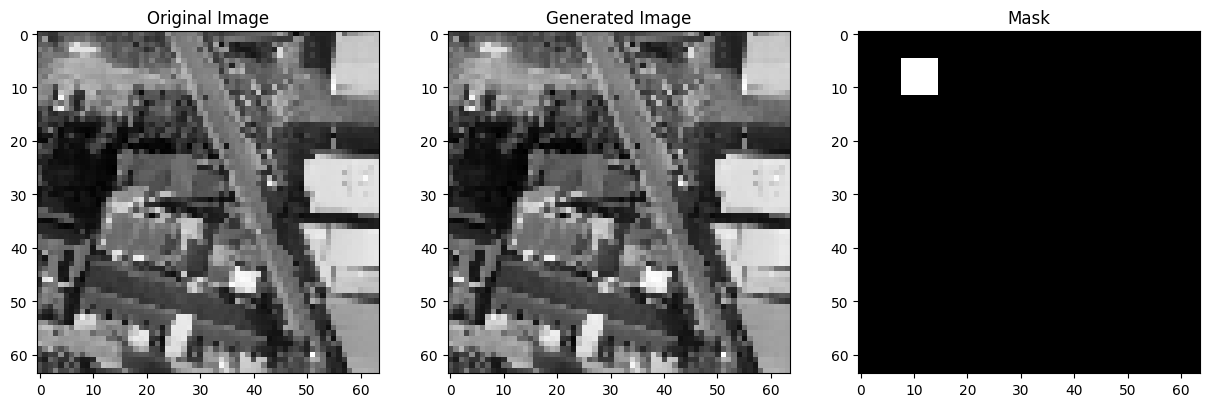

MSE Loss at Masked Area: 0.0000


In [23]:
# prompt: load the image /content/val/img0000.png, put the black box, get the complete image using the trained model and then plot the original image, the complete image and the mse loss at the area of the black box indicated by the mask

import numpy as np
import matplotlib.pyplot as plt

# Load the image
image_path = '/workspace/val/img0001.png'
image = Image.open(image_path).convert('L')  # Convert to grayscale

# Apply transformations (if any)
if transform:
    image = transform(image)

# Create masked image
processed_image, mask = create_masked_image(np.array(image))

# Convert to PyTorch tensors
image_tensor = transforms.ToTensor()(image).unsqueeze(0).to(device)  # Add batch dimension
processed_image_tensor = transforms.ToTensor()(processed_image).unsqueeze(0).to(device)
mask_tensor = transforms.ToTensor()(mask).unsqueeze(0).to(device)

# Generate the completed image
generator.eval()
with torch.no_grad():
    generated_image_tensor = generator(processed_image_tensor)

# Calculate MSE loss at the masked area
mse_loss = nn.MSELoss()(generated_image_tensor * mask_tensor, image_tensor * mask_tensor)

# Convert tensors to NumPy arrays for plotting
original_image = image_tensor.squeeze(0).cpu().numpy().transpose(1, 2, 0)
generated_image = generated_image_tensor.squeeze(0).cpu().numpy().transpose(1, 2, 0)
mask_array = mask_tensor.squeeze(0).cpu().numpy().transpose(1, 2, 0)

# Plot the images
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].imshow(original_image, cmap='gray')
axes[0].set_title('Original Image')
axes[1].imshow(generated_image, cmap='gray')
axes[1].set_title('Generated Image')
axes[2].imshow(mask_array, cmap='gray')
axes[2].set_title('Mask')
plt.show()

print(f"MSE Loss at Masked Area: {mse_loss.item():.4f}")


# ทดลองใช้งานกับข้อมูลชุดทดสอบ

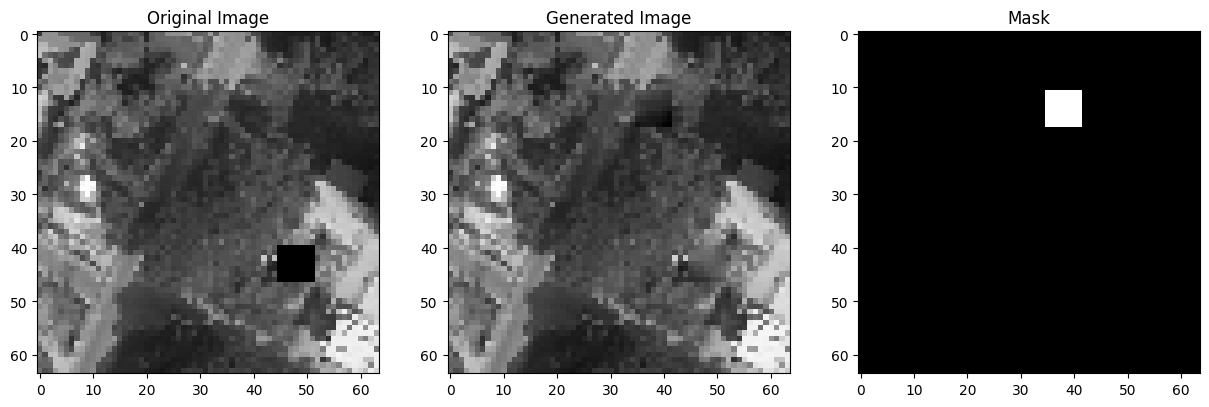

MSE Loss at Masked Area: 0.0001


In [27]:
# prompt: load the image /content/test/img0000.png,  get the complete image using the trained model and then plot the original image, the complete image and the mse loss at the area  indicated by the mask at  /content/test_mask/img0000.png

import matplotlib.pyplot as plt
# Load the image
image_path = '/workspace/test/img0010.png'
image = Image.open(image_path).convert('L')  # Convert to grayscale

# Load the mask
mask_path = '/workspace/test_mask/img0000.png'
mask = Image.open(mask_path).convert('L')

# Apply transformations (if any)
# if transform:
#     image = transform(image)
#     mask = transform(mask)

# Convert to PyTorch tensors
image_tensor = transforms.ToTensor()(image).unsqueeze(0).to(device)  # Add batch dimension
mask_tensor = transforms.ToTensor()(mask).unsqueeze(0).to(device)

# Create a masked image (black out the masked area)
processed_image_tensor = image_tensor * (1 - mask_tensor)

# Generate the completed image
generator.eval()
with torch.no_grad():
    generated_image_tensor = generator(processed_image_tensor)

# Calculate MSE loss at the masked area
mse_loss = nn.MSELoss()(generated_image_tensor * mask_tensor, image_tensor * mask_tensor)

# Convert tensors to NumPy arrays for plotting
original_image = image_tensor.squeeze(0).cpu().numpy().transpose(1, 2, 0)
generated_image = generated_image_tensor.squeeze(0).cpu().numpy().transpose(1, 2, 0)
mask_array = mask_tensor.squeeze(0).cpu().numpy().transpose(1, 2, 0)

# Plot the images
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].imshow(original_image, cmap='gray')
axes[0].set_title('Original Image')
axes[1].imshow(generated_image, cmap='gray')
axes[1].set_title('Generated Image')
axes[2].imshow(mask_array, cmap='gray')
axes[2].set_title('Mask')
plt.show()

print(f"MSE Loss at Masked Area: {mse_loss.item():.4f}")



# ทำนายภาพใน test set และเตรียมส่งตามรูปแบบที่กำหนด

In [25]:
# prompt: complete all image in /content/test where the mask is provided at /content/test_mask and the /content/test_bb.csv contain file name and the position of the bounding box, img_path, top,, then produce csv output having 2 columns. The first column contains file id in format {file name with out extension}_{row}_{column} e.g. img000_5_12. The second column contains intensity value in the rang [0, 255]

import pandas as pd

# Load bounding box data
bb_df = pd.read_csv('/workspace/test_mask.csv')

# Prepare output list
output_data = []

# Loop through test images
for index, row in bb_df.iterrows():
    img_path = row['img_path']
    top = int(row['top'])
    left = int(row['left'])  # Assuming 'left' column exists

    # Load masked image and mask
    masked_image_path = os.path.join('/workspace/test', img_path)
    mask_path = os.path.join('/workspace/test_mask', img_path)
    masked_image = Image.open(masked_image_path).convert('L')
    mask = Image.open(mask_path).convert('L')

    # Apply transformations (if any)
    if transform:
        masked_image = transform(masked_image)
        mask = transform(mask)

    # Convert to PyTorch tensors
    masked_image_tensor = transforms.ToTensor()(masked_image).unsqueeze(0).to(device)
    mask_tensor = transforms.ToTensor()(mask).unsqueeze(0).to(device)

    # Generate the completed image
    generator.eval()
    with torch.no_grad():
        generated_image_tensor = generator(masked_image_tensor)

    # Extract pixel values within the bounding box
    generated_image_np = generated_image_tensor.squeeze(0).cpu().numpy().transpose(1, 2, 0)
    for i in range(top, top + 7):
        for j in range(left, left + 7):
            intensity = generated_image_np[i, j, 0] * 255  # Scale to [0, 255]
            file_id = img_path.split('.')[0] + f'_{i}_{j}'
            output_data.append([file_id, intensity])

# Create DataFrame and save to CSV
output_df = pd.DataFrame(output_data, columns=['location', 'value'])
output_df.to_csv('base_line_solution.csv', index=False)


Average MSE Loss for all images: 0.0000


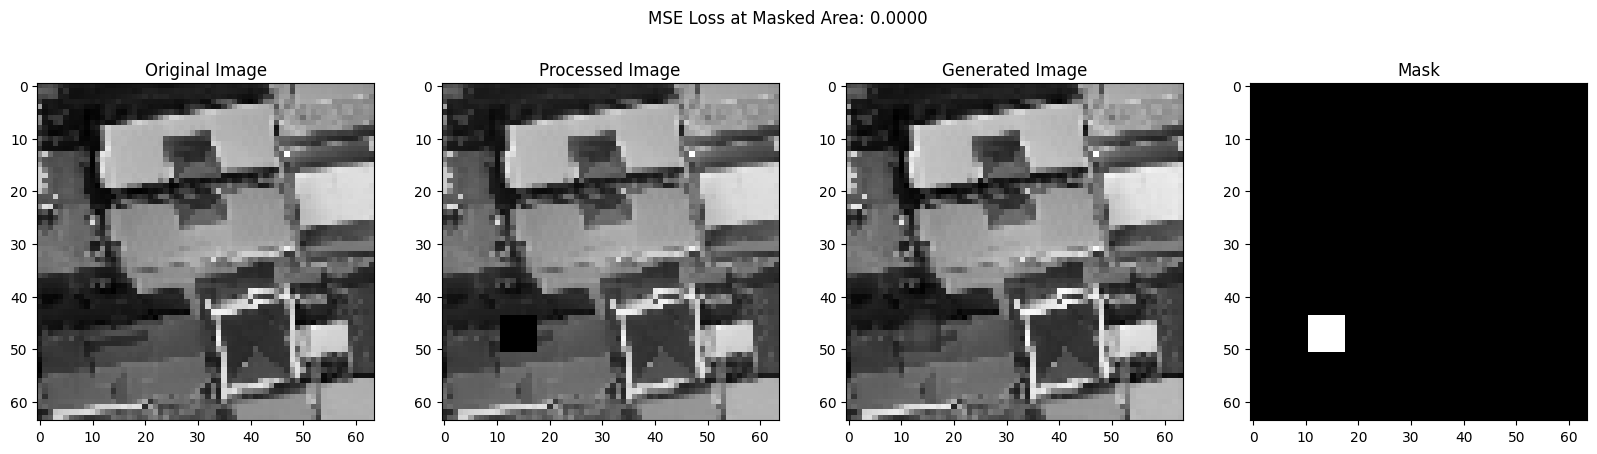

In [28]:
def calculate_mse(generator, dataloader, device):
    mse_losses = []
    generator.eval()
    mse_criterion = nn.MSELoss()

    with torch.no_grad():
        for original_image, processed_image, mask in dataloader:
            original_image = original_image.to(device)
            processed_image = processed_image.to(device)
            mask = mask.to(device)

            generated_image = generator(processed_image)
            mse_loss = mse_criterion(generated_image * mask, original_image * mask)
            mse_losses.append(mse_loss.item())

    return mse_losses

def plot_results(original_image, processed_image, generated_image, mask, mse_loss):
    fig, axes = plt.subplots(1, 4, figsize=(20, 5))
    axes[0].imshow(original_image.squeeze().cpu().numpy(), cmap='gray')
    axes[0].set_title('Original Image')
    axes[1].imshow(processed_image.squeeze().cpu().numpy(), cmap='gray')
    axes[1].set_title('Processed Image')
    axes[2].imshow(generated_image.squeeze().cpu().numpy(), cmap='gray')
    axes[2].set_title('Generated Image')
    axes[3].imshow(mask.squeeze().cpu().numpy(), cmap='gray')
    axes[3].set_title('Mask')
    plt.suptitle(f"MSE Loss at Masked Area: {mse_loss:.4f}")
    plt.show()

# Main execution
if __name__ == "__main__":
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    

    
    # Set the path to your validation folder
    val_folder = '/workspace/val/'
    
    # Define transformations
    transform = transforms.Compose([
        # transforms.Resize((256, 256))
        # Add other transformations as needed
    ])
    
    # Create dataset and dataloader
    dataset = ImageInpaintingDataset(val_folder, transform=transform)
    dataloader = DataLoader(dataset, batch_size=1, shuffle=False)
    
    # Calculate MSE losses
    mse_losses = calculate_mse(generator, dataloader, device)
    
    # Calculate and print average MSE loss
    avg_mse_loss = sum(mse_losses) / len(mse_losses)
    print(f"Average MSE Loss for all images: {avg_mse_loss:.4f}")
    
    # Plot results for a single image (e.g., the first image)
    original_image, processed_image, mask = next(iter(dataloader))
    original_image = original_image.to(device)
    processed_image = processed_image.to(device)
    mask = mask.to(device)
    
    generator.eval()
    with torch.no_grad():
        generated_image = generator(processed_image)
    
    mse_loss = nn.MSELoss()(generated_image * mask, original_image * mask)
    plot_results(original_image, processed_image, generated_image, mask, mse_loss.item())